In [1]:
# Q.liu
# GLCM analysis 
# 26/09.2017
import numpy as np
import cv2
import os
import time
import sys
import matplotlib.pyplot as plt

gray image size:  (256, 256)


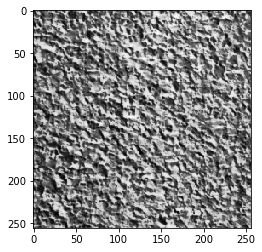

In [2]:
image_path = './output/subimg-mosaic1-1.png'

img = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
print('gray image size: ',img.shape)
plt.imshow(img,'gray')
plt.show()


In [3]:
# define glcm window size : min_row = 0, max_row = 2 * win_oder, min_col = 0, max_col = max_row
# window shape = (2*win_oder+1) x (2*win_oder+1)

win_order = 2 # default 2, just for test and debug
win_shape = (2*win_order+1, 2*win_order+1) # window shape - 5 x 5
boundary_fill = 'constant' # or 'mirror'
fill_val = 0

win_img = np.zeros(win_shape)

print('Define glcm window shape: 5x5','\n',win_img)

Define glcm window shape: 5x5 
 [[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]


In [5]:
img_row, img_col = img.shape # in this case, img_row = img_col = 256

img_i = 0 # row index in the image 
img_j = 0 # col index in the image

win_oder = 2
# win_i = img_i - win_order, win_j = img_j - win_oder

if boundary_fill is 'constant':  # or 'mirror'
    for row_offset in range (-1 * win_order, win_order+1):        
        for col_offset in range (-1 * win_oder, win_order+1):            
            if (img_i + row_offset) < 0 or (img_j + col_offset) < 0:
                win_img[win_order + row_offset, win_order + col_offset] = fill_val
            else:
                win_img[win_order + row_offset, win_order + col_offset] = img[img_i + row_offset, img_j + col_offset]
else: # mirror
    for row_offset in range (-1 * win_oder, win_order+1):        
        for col_offset in range (-1 * win_oder, win_order+1): 
            win_img[win_order + row_offset, win_order + col_offset] = img[abs(img_i + row_offset), abs(img_j + col_offset)]


print('sliding and copy window image on the image \n', win_img)


sliding and copy window image on the image 
 [[   0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.]
 [   0.    0.   48.   76.  149.]
 [   0.    0.   49.   28.   55.]
 [   0.    0.   76.   35.   29.]]


In [6]:
# wrap above code as a general function

def glcm_window_img(gray_image, neighbor=2, current_row=0, current_col=0, fill='constant'):
    """
    Get an glcm window image given defined neghbourhood or window size on the original image with
    specific pixel location index

    :param gray_image: input gray level image
    :param neighbor: window order - size defined by neighborhood
    :param current_row: give current location of pixel - row index
    :param current_col: give current location of pixel - column index
    :param fill: boundary filling flag, now only have 2 types, constant or mirror
    :return: window image
    """
    max_row, max_col = gray_image.shape
    win_shape = (2 * neighbor + 1, 2 * neighbor + 1)  # window shape - 5 x 5
    win_img = np.zeros(win_shape)

    for row_offset in range(-1 * neighbor, neighbor + 1):
        for col_offset in range(-1 * neighbor, neighbor + 1):
            cp_i = current_row + row_offset
            cp_j = current_col + col_offset
            if 0 <= cp_i < max_row and 0 <= cp_j < max_col:
                win_img[neighbor + row_offset, neighbor + col_offset] = gray_image[cp_i, cp_j]
            else:
                if fill is 'constant':
                    win_img[neighbor + row_offset, neighbor + col_offset] = 0
                elif fill is 'mirror':
                    if cp_i >= max_row: 
                        cp_i = max_row - row_offset
                    if cp_j >= max_col: 
                        cp_j = max_col - col_offset
                    if cp_i < 0: 
                        cp_i = -1 - cp_i
                    if cp_j < 0: 
                        cp_j = -1 - cp_j

                    win_img[neighbor + row_offset, neighbor + col_offset] = gray_image[cp_i, cp_j]

    return win_img


In [7]:
# calculate time 
start_time = time.time()
win_img2 = glcm_window_img(img, 2, 0, 255,'constant')
print('runtime: ',time.time()-start_time)

runtime:  0.00016021728515625


In [8]:
# Compute GLCM matrix with requantization 
grey_levels = np.unique(win_img)
level_lst = list(grey_levels)

print('grey levels of input window image: \n',level_lst[1])

num_levels = len(grey_levels) 
glcm = np.zeros([num_levels, num_levels]) # initialize a glcm matrix based on input a window image

print('initial glcm matrix: \n', glcm)

grey levels of input window image: 
 28.0
initial glcm matrix: 
 [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [9]:
# requantize image before GLCM
level_space = np.linspace(0,255, 8)
M, N = win_img.shape
out_img = np.zeros([M, N], dtype='uint8')
for i in range(M):
    for j in range(N):
        out_img[i,j] = min(level_space,key=lambda x: abs(x - win_img[i,j]))
    
print(out_img)
grey_levels = np.unique(out_img)
level_lst = list(grey_levels)

print('grey levels of input window image after requantization with level-8: \n',level_lst)

num_levels = len(grey_levels) 
glcm = np.zeros([num_levels, num_levels]) # initialize a glcm matrix based on input a window image
print('initial glcm matrix: \n', glcm)

[[  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0  36  72 145]
 [  0   0  36  36  72]
 [  0   0  72  36  36]]
grey levels of input window image after requantization with level-8: 
 [0, 36, 72, 145]
initial glcm matrix: 
 [[ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]


In [10]:
# wrap out a general requantize function
def requantize(image, level_num=8):
    """
    Perform requantization on input gray image
    :param img: Gray image or 2-D array
    :param level_num:
    :return: 2-D image
    """
    M, N = image.shape
    level_space = np.linspace(0,255,level_num)
    out_img = np.zeros([M,N],dtype='uint8')
    for i in range(M):
        for j in range(N):
            out_img[i,j] = min(level_space,key=lambda x: abs(x-image[i,j]))

    return out_img.astype('uint8')

print('window image before requantize by level=8: \n', win_img)
win_img_req = requantize(win_img, 8)
print('window image after requantized by level=8: \n', win_img_req)


window image before requantize by level=8: 
 [[   0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.]
 [   0.    0.   48.   76.  149.]
 [   0.    0.   49.   28.   55.]
 [   0.    0.   76.   35.   29.]]
window image after requantized by level=8: 
 [[  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0  36  72 145]
 [  0   0  36  36  72]
 [  0   0  72  36  36]]


In [11]:
# 
# basic (1-order statistic) texture features for gray-level images.

def basic_info(image):
    """
    Perform some basic (1-order statistic) texture features for gray-level images.
    :param image: 2-D gray-level image
    :return: info_list, some basic features
    """
    info_list = {'min': 0, 'max': 0,
                 'mean': 0, 'std_dev': 0,
                 'skewness': 0, 'kurtosis': 0,
                 'entropy': 0, 'energy': 0,
                 'smoothness': 0, 'coefficient': 0}
    #hist, - = np.histogram(image.flatten(), bins=256, range=[0, 255], density=False)

    info_list['min'] = image.min()
    info_list['max'] = image.max()

    #hist = cv2.calcHist(image,[0],None,[256],[0,256])
    hist,_ = np.histogram(image.flatten(), bins=256, range=[0, 255], density=False)
    hx = hist.ravel()/hist.sum()
    # mean = np.mean(image.flatten())
    x = np.arange(256)
    mean = hx.dot(x)

    info_list['mean'] = mean
    variance = ((x - mean)**2).dot(hx)
    std = np.sqrt(variance)
    info_list['std_dev'] = std
    info_list['skewness'] = ((x - mean)**3).dot(hx)/std**3          # different with lecture notes
    info_list['kurtosis'] = (((x - mean)**4)*hx).sum()/std**4 - 3    # different with lecture notes
    info_list['energy'] = (hx*hx).sum()
    info_list['smoothness'] = 1 - 1/(1+variance)
    info_list['coefficient'] = std/mean

    # ref: https://stackoverflow.com/questions/16647116/faster-way-to-analyze-each-sub-window-in-an-image
    log_h = np.log2(hx+0.00001)
    info_list['entropy'] = -1 * (log_h*hx).sum()

    return info_list

print(basic_info(img))


{'min': 0, 'max': 255, 'mean': 123.93272399902344, 'std_dev': 60.916432453489847, 'skewness': 0.13262348035042767, 'kurtosis': -1.1908930272377334, 'entropy': 6.3339059678261087, 'energy': 0.014305692166090012, 'smoothness': 0.9997305897849148, 'coefficient': 0.49152822989648687}


In [12]:
# computing glcm
req_img = requantize(img)
win_img = glcm_window_img(req_img,2)
M, N = win_img.shape
print('window image size', M)
print(win_img)

levels = list(np.unique(win_img))
num_levels = len(levels)

glcm = np.zeros([num_levels, num_levels],dtype='uint8')
print('intialized GL coocurrence matrix: ')
print(glcm)
print(levels)

window image size 5
[[   0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.]
 [   0.    0.   36.   72.  145.]
 [   0.    0.   36.   36.   72.]
 [   0.    0.   72.   36.   36.]]
intialized GL coocurrence matrix: 
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
[0.0, 36.0, 72.0, 145.0]


In [13]:
# compute horizontal glcm 

i_range = list(range(M))
j_range = list(range(N-1))
print(levels)
for i in i_range:
    for j in j_range:
        pixel_1 = win_img[i,j]
        pixel_2 = win_img[i,j+1]        
        co_i = levels.index(pixel_1)
        co_j = levels.index(pixel_2)
        glcm[co_i,co_j] += 1
        
        
print(glcm)

[0.0, 36.0, 72.0, 145.0]
[[11  2  1  0]
 [ 0  2  2  0]
 [ 0  1  0  1]
 [ 0  0  0  0]]


In [14]:
# compute vertical glcm 

i_range = list(range(M-1))
j_range = list(range(N))
glcm[:] = 0
print(levels)
for i in i_range:
    for j in j_range:
        pixel_1 = win_img[i,j]
        pixel_2 = win_img[i+1,j]        
        co_i = levels.index(pixel_1)
        co_j = levels.index(pixel_2)
        glcm[co_i,co_j] += 1
        
        
print(glcm)

[0.0, 36.0, 72.0, 145.0]
[[11  1  1  1]
 [ 0  2  1  0]
 [ 0  2  0  0]
 [ 0  0  1  0]]


In [15]:
# symmetric GLCM
glcm_t = glcm.T
glcm += glcm_t
print(glcm)

[[22  1  1  1]
 [ 1  4  3  0]
 [ 1  3  0  1]
 [ 1  0  1  0]]


In [16]:
# normalization
total_sum = sum(glcm.flatten())
glcm = glcm / float(total_sum)
print(glcm)


[[ 0.55   0.025  0.025  0.025]
 [ 0.025  0.1    0.075  0.   ]
 [ 0.025  0.075  0.     0.025]
 [ 0.025  0.     0.025  0.   ]]


In [17]:
# compute -45 degree angle glcm 

i_range = list(range(M-1))
j_range = list(range(N-1))
glcm[:] = 0
print(levels)
for i in i_range:
    for j in j_range:
        pixel_1 = win_img[i,j]
        pixel_2 = win_img[i+1,j+1]        
        co_i = levels.index(pixel_1)
        co_j = levels.index(pixel_2)
        glcm[co_i,co_j] += 1
        
        
print(glcm)

[0.0, 36.0, 72.0, 145.0]
[[ 7.  2.  2.  1.]
 [ 0.  3.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  0.]]


In [18]:
# compute +45 degree angle glcm 

i_range = list(range(1,M))
j_range = list(range(N-1))
glcm[:] = 0
print(levels)
for i in i_range:
    for j in j_range:
        pixel_1 = win_img[i,j]
        pixel_2 = win_img[i-1,j+1]        
        co_i = levels.index(pixel_1)
        co_j = levels.index(pixel_2)
        glcm[co_i,co_j] += 1
        
        
print(glcm)

[0.0, 36.0, 72.0, 145.0]
[[ 8.  2.  0.  0.]
 [ 1.  0.  2.  1.]
 [ 1.  1.  0.  0.]
 [ 0.  0.  0.  0.]]


In [90]:
# wrap above code to a general function
def direction_glcm(win_image, direction='horizontal', step=1 , weight=1):
    """
    four directions
    
                diagonal1 45 degree
               .
             .
           .
         .
       .
     ............ horizontal
     ..
     .  .
     .    .
     .      .
     .        .
     .          .diagonal2 -45 degree
     
    vertical
    
    """
    M, N = win_image.shape
    levels = list(np.unique(win_image))
    num_levels = len(levels)

    glcm = np.zeros([num_levels, num_levels],dtype='uint8')
    
    if direction is 'horizontal':        
        i_range = list(range(M))
        j_range = list(range(N-step))
        for i in i_range:
            for j in j_range:
                pixel_1 = win_image[i,j]
                pixel_2 = win_image[i,j+step]        
                co_i = levels.index(pixel_1)
                co_j = levels.index(pixel_2)
                glcm[co_i,co_j] += weight
    elif direction is 'vertical':
        i_range = list(range(M-step))
        j_range = list(range(N))
        for i in i_range:
            for j in j_range:
                pixel_1 = win_image[i,j]
                pixel_2 = win_image[i+step,j]        
                co_i = levels.index(pixel_1)
                co_j = levels.index(pixel_2)
                glcm[co_i,co_j] += weight
    elif direction is 'diagonal1': # 45 degree direction
        i_range = list(range(step,M))
        j_range = list(range(N-step))
        for i in i_range:
            for j in j_range:
                pixel_1 = win_image[i,j]
                pixel_2 = win_image[i-step,j+step]        
                co_i = levels.index(pixel_1)
                co_j = levels.index(pixel_2)
                glcm[co_i,co_j] += weight
    elif direction is 'diagonal2': # -45 degree direction
        i_range = list(range(M-step))
        j_range = list(range(N-step))
        for i in i_range:
            for j in j_range:
                pixel_1 = win_image[i,j]
                pixel_2 = win_image[i+step,j+step]        
                co_i = levels.index(pixel_1)
                co_j = levels.index(pixel_2)
                glcm[co_i,co_j] += weight
    
    return glcm

In [91]:
glcm_45 = direction_glcm(win_img, 'diagonal2')
print(glcm_45)

[[7 2 2 1]
 [0 3 0 0]
 [0 0 1 0]
 [0 0 0 0]]


In [99]:
# compute isotropic glcm
def isotropic_glcm(win_image, step=1, weights=None):
    if weights is None:
        weights = [0.25, 0.25, 0.25, 0.25]
    glcm = direction_glcm(win_image, 'horizontal', step) * weights[0]
    glcm += direction_glcm(win_image, 'vertical', step) * weights[1]
    glcm += direction_glcm(win_image, 'diagonal1', step) * weights[2]
    glcm += direction_glcm(win_image, 'diagonal2', step) * weights[3]
    return glcm

#test this function
iso_glcm = isotropic_glcm(win_img)
print(iso_glcm)

[[ 9.25  1.75  1.    0.5 ]
 [ 0.25  1.75  1.25  0.25]
 [ 0.25  1.    0.25  0.25]
 [ 0.    0.    0.25  0.  ]]


In [94]:
# symmetrisation and normalization
sym_glcm = iso_glcm + iso_glcm.T
norm_glcm = sym_glcm / float(sum(sym_glcm.flatten()))
print ('Symmetric isotropic GLCM \n',sym_glcm)
print ('Nomalized symmetric isotropic GLCM \n',norm_glcm)

Symmetric isotropic GLCM 
 [[ 18.5    2.     1.25   0.5 ]
 [  2.     3.5    2.25   0.25]
 [  1.25   2.25   0.5    0.5 ]
 [  0.5    0.25   0.5    0.  ]]
Nomalized symmetric isotropic GLCM 
 [[ 0.51388889  0.05555556  0.03472222  0.01388889]
 [ 0.05555556  0.09722222  0.0625      0.00694444]
 [ 0.03472222  0.0625      0.01388889  0.01388889]
 [ 0.01388889  0.00694444  0.01388889  0.        ]]


In [34]:
# start to compute glcm meatures/features, 
# 1 max probability
max_prob = np.max(norm_glcm.flatten())
print ('max probability: ',max_prob)

# 2 contrast / inertia
M, N = norm_glcm.shape

contr_weights = np.zeros([M,N])
for i in range(M):
    for j in range(N):
        contr_weights[i,j] = (i-j)**2
        
contrast = norm_glcm.flatten().dot(contr_weights.flatten())
print('contrast/inertia: ',contrast)

# 3 dissimilarity 
dissi_weights = np.zeros([M,N])
for i in range(M):
    for j in range(N):
        dissi_weights[i,j] = abs(i-j)

dissimilarity = norm_glcm.flatten().dot(dissi_weights.flatten())
print('dissimilarity: ',dissimilarity)

# 4 homogeneity
homo_weights = np.zeros([M,N])
for i in range(M):
    for j in range(N):
        homo_weights[i,j] = 1/(1+(i-j)**2)

homogeneity = norm_glcm.flatten().dot(homo_weights.flatten())
print('homogeneity: ',homogeneity)

# orderliness measures
# A - angular second moment (ASM)
asm = norm_glcm.flatten().dot(norm_glcm.flatten())
print('angular second moment: ',asm)

# B - Energy sqrt(ASM)
energy = np.sqrt(asm)
print('energy: ',energy)

# C - Entropy
# ln = np.log(norm_glcm) here, log(0) = -inf, will have some problem, using np.ma.log instead
# np.ma.log(0) = -- : not -inf. ? can pass 
ln = np.ma.log(norm_glcm)
entropy = -np.dot(norm_glcm.flatten(),ln.flatten())
print('entropy: ',entropy)

max probability:  0.513888888889
contrast/inertia:  0.847222222222
dissimilarity:  0.513888888889
homogeneity:  0.776388888889
angular second moment:  0.290991512346
energy:  0.539436291276
entropy:  1.83582317804


In [76]:
# descriptive statistic 
# 1- GLCM mean
# 2- variance
# 3- correlation
# 4- cluster shade
num_greylevel = len(np.unique(win_img))

index_i = np.arange(0,num_greylevel) # row index
index_j = index_i # column index = row 

sum_v = np.sum(iso_glcm, axis=0) # sum column[] , vertical
sum_h = np.sum(iso_glcm, axis=1) # sum row[] , horizontal

mean_i = np.dot(index_i, sum_h.flatten()) 
mean_j = np.dot(index_j, sum_v.flatten())
print('isotropic glcm : \n', iso_glcm)
print('sum column :', sum_v,'\n', 'sum row :',sum_h)
print('mean_i: {0} and mean_j: {1}'.format(mean_i,mean_j))

var_i = np.dot((index_i-mean_i)**2, sum_h.flatten()) 
var_j = np.dot((index_j-mean_j)**2, sum_v.flatten()) 
print('varance_i: {0} and varance_j: {1}'.format(var_i,var_j))
stdev_i = np.sqrt(var_i)
stdev_j = np.sqrt(var_j)
print('standard dev_i: {0} and standard dev_j: {1} '.format(stdev_i,stdev_j))

correlation = np.dot(iso_glcm.flatten(),
                     np.outer((index_i-mean_i),(index_j-mean_j)).flatten())/(stdev_i * stdev_j)

print('correlation :', correlation)

cluster_weights = np.zeros([num_greylevel,num_greylevel])

for i in range(num_greylevel):
    for j in range(num_greylevel):
        cluster_weights[i,j] = (i + j - mean_i - mean_j)**3

cluster_shade = np.dot(iso_glcm.flatten(), cluster_weights.flatten())
print('cluster_shade :', cluster_shade)


isotropic glcm : 
 [[37  7  4  2]
 [ 1  7  5  1]
 [ 1  4  1  1]
 [ 0  0  1  0]]
sum column : [39 18 11  4] 
 sum row : [50 14  7  1]
mean_i: 31.0 and mean_j: 52.0
varance_i: 67321.0 and varance_j: 189378.0
standard dev_i: 259.4629067901614 and standard dev_j: 435.17582653451694 
correlation : 0.999752152816
cluster_shade : -39511537.0


In [98]:
# wrapping above code to a general function 

def symmetrise(glcm):
    return glcm + glcm.T

def normalize(glcm):
    return glcm / float(sum(glcm.flatten()))

def glcm_measures(glcm, name=None, normed=False, symmetric=False):
    """
    Perform computing all kinds of measures/features based on a given glcm
    :param glcm: input glcm matrix
    :param name: measure's name, if none, return all measures
    :param normed: if normalize the glcm before measuring it
    :param symmetric: if symmetrise the glcm before measuring it
    :return: a measure values or a measure list
    """
    measure_list = dict(max_prob=0, contrast=0, dissimilarity=0, homogeneity=0, ASM=0, energy=0, entropy=0,
                        correlation=0, cluster_shade=0, variance_i=0, variance_j=0, mean_i=0, mean_j=0)


    M, N = glcm.shape

    if symmetric:
        # symmetrisation
        glcm = symmetrise(glcm)
        if normed:
            glcm = normalize(glcm)
    else:
        if normed:
            glcm = normalize(glcm)

    flat_glcm = glcm.flatten()
    index_i = np.arange(0, M)  # row index
    index_j = np.arange(0, N)  # column index = row

    sum_v = np.sum(glcm, axis=0)  # sum column[] , vertical
    sum_h = np.sum(glcm, axis=1)  # sum row[] , horizontal

    mean_i = np.dot(index_i, sum_h.flatten())
    mean_j = np.dot(index_j, sum_v.flatten())

    var_i = np.dot((index_i - mean_i) ** 2, sum_h.flatten())
    var_j = np.dot((index_j - mean_j) ** 2, sum_v.flatten())

    stdev_i = np.sqrt(var_i)
    stdev_j = np.sqrt(var_j)

    contrast_weights = np.zeros([M, N])
    dissi_weights = np.zeros([M, N])
    homo_weights = np.zeros([M, N])
    cluster_weights = np.zeros([M, N])
    correl_weights = np.outer((index_i - mean_i), (index_j - mean_j)) / (stdev_i * stdev_j)

    for i in range(M):
        for j in range(N):
            contrast_weights[i, j] = (i - j) ** 2
            dissi_weights[i, j] = abs(i - j)
            homo_weights[i, j] = 1 / (1 + (i - j) ** 2)
            cluster_weights[i, j] = (i + j - mean_i - mean_j) ** 3

    max_prob = np.max(flat_glcm)
    ASM = np.dot(flat_glcm, flat_glcm)
    energy = np.sqrt(ASM)

    # ln = np.log(flat_glcm) here, log(0) = -inf, will have some problem, using np.ma.log instead
    # np.ma.log(0) = -- : not -inf. ? can pass
    ln = np.ma.log(flat_glcm)
    entropy = -np.dot(flat_glcm, ln)

    contrast = np.dot(flat_glcm, contrast_weights.flatten())
    dissimilarity = np.dot(flat_glcm, dissi_weights.flatten())
    homogeneity = np.dot(flat_glcm, homo_weights.flatten())
    correlation = np.dot(flat_glcm, correl_weights.flatten())
    # cluster_shade = np.dot(flat_glcm, cluster_weights.flatten())
    cluster_shade = np.dot(glcm.flatten(), cluster_weights.flatten())

    measure_list['max_prob'] = max_prob
    measure_list['contrast'] = contrast
    measure_list['dissimilarity'] = dissimilarity
    measure_list['homogeneity'] = homogeneity
    measure_list['ASM'] = ASM
    measure_list['energy'] = energy
    measure_list['entropy'] = entropy
    measure_list['correlation'] = correlation
    measure_list['cluster_shade'] = cluster_shade
    measure_list['variance_i'] = var_i
    measure_list['variance_j'] = var_j
    measure_list['mean_i'] = mean_i
    measure_list['mean_j'] = mean_j

    if name in measure_list.keys():
        return measure_list[name]
    else:
        return measure_list
# test this function
print(glcm_measures(iso_glcm))
print(glcm_measures(iso_glcm, normed=True, symmetric=True))


{'max_prob': 9.25, 'contrast': 15.25, 'dissimilarity': 9.25, 'homogeneity': 13.975, 'ASM': 95.875, 'energy': 9.7915780137830701, 'entropy': -20.389337416557023, 'correlation': 0.99570985468788675, 'cluster_shade': -137506.140625, 'variance_i': 973.75, 'variance_j': 2728.5, 'mean_i': 7.75, 'mean_j': 13.0}
{'max_prob': 0.51388888888888884, 'contrast': 0.84722222222222221, 'dissimilarity': 0.51388888888888884, 'homogeneity': 0.7763888888888888, 'ASM': 0.29099151234567894, 'energy': 0.53943629127606807, 'entropy': 1.8358231780441119, 'correlation': 0.39699320381684633, 'cluster_shade': 2.4996088391632374, 'variance_i': 0.70249807098765438, 'variance_j': 0.70249807098765438, 'mean_i': 0.57638888888888884, 'mean_j': 0.57638888888888884}


gray image size:  (256, 256)


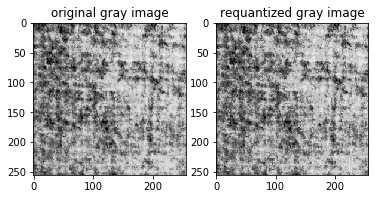

first order measures for original image 
 {'min': 0, 'max': 255, 'mean': 147.87979125976562, 'std_dev': 48.140692987774351, 'skewness': -0.40414360474120636, 'kurtosis': -0.63926774054098701, 'entropy': 5.6410686519147468, 'energy': 0.024447472300380468, 'smoothness': 0.99956869154738748, 'coefficient': 0.32553936259762778} 

first order measures for requantized image 
 {'min': 0, 'max': 255, 'mean': 146.53927612304688, 'std_dev': 48.411614949563813, 'skewness': -0.39543173338045151, 'kurtosis': -0.67123218349767155, 'entropy': 2.6758427538184764, 'energy': 0.17660430818796158, 'smoothness': 0.99957350337915563, 'coefficient': 0.33036613957962568}

 sliding window from pixel(0,0)


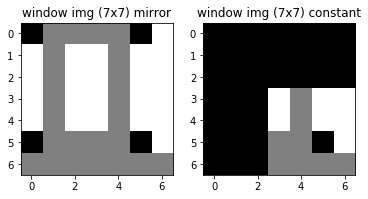

mirror window 
 [[  0.  28.  28.  28.  28.   0.  56.]
 [ 56.  28.  56.  56.  28.  56.  56.]
 [ 56.  28.  56.  56.  28.  56.  56.]
 [ 56.  28.  56.  56.  28.  56.  56.]
 [ 56.  28.  56.  56.  28.  56.  56.]
 [  0.  28.  28.  28.  28.   0.  56.]
 [ 28.  28.  28.  28.  28.  28.  28.]] 

constant window 
 [[  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.  56.  28.  56.  56.]
 [  0.   0.   0.  56.  28.  56.  56.]
 [  0.   0.   0.  28.  28.   0.  56.]
 [  0.   0.   0.  28.  28.  28.  28.]]


In [130]:
# now test all functions from begining
image_file = './output/subimg-mosaic1-2.png'

gray_img = cv2.imread(image_file,cv2.IMREAD_GRAYSCALE)  # read image by opencv as grayscale 
print('gray image size: ',gray_img.shape)
plt.figure(1)
plt.subplot(1,2,1)
plt.imshow(gray_img,'gray')
plt.title('original gray image')

req_img = requantize(gray_img, level_num = 10)  # requantize the gray img
plt.subplot(1,2,2)
plt.imshow(req_img,'gray')
plt.title('requantized gray image')
plt.show()

print('first order measures for original image \n',basic_info(gray_img), '\n') 
print('first order measures for requantized image \n',basic_info(req_img))

glcm_img1 = glcm_window_img(req_img, neighbor=3, current_row = 0, current_col=0, fill='mirror') # sliding window
glcm_img2 = glcm_window_img(req_img, neighbor=3, current_row = 0, current_col=0, fill='constant')
print('\n sliding window from pixel(0,0)')
plt.figure(2)
plt.subplot(1,2,1)
plt.imshow(glcm_img1,'gray')
plt.title('window img ({0}x{1}) mirror'.format(glcm_img1.shape[0],glcm_img1.shape[1]))

plt.subplot(1,2,2)
plt.imshow(glcm_img2,'gray')
plt.title('window img ({0}x{1}) constant'.format(glcm_img2.shape[0],glcm_img2.shape[1]))
plt.show()

print('mirror window \n', glcm_img1, '\n')
print('constant window \n', glcm_img2)

In [129]:
# now test glcm functions
print('Test glcm functions on mirror window img')
glcm_h = direction_glcm(glcm_img1, direction='horizontal')
glcm_v = direction_glcm(glcm_img1, direction='vertical')
glcm_d1 = direction_glcm(glcm_img1, direction='diagonal1')
glcm_d2 = direction_glcm(glcm_img1, direction='diagonal2')
glcm_ist = isotropic_glcm(glcm_img1)
glcm_symm = symmetrise(glcm_ist)
glcm_norm = normalize(glcm_symm)

print('glcm_h \n', glcm_h, '\n')
print('glcm_v \n', glcm_v, '\n')
print('glcm_d1 \n', glcm_d1, '\n')
print('glcm_d2 \n', glcm_d2, '\n')
print('glcm_ist \n', glcm_ist, '\n')
print('glcm_symm \n', glcm_symm, '\n')
print('glcm_norm \n', glcm_norm)

Test glcm functions on mirror window img
glcm_h 
 [[ 0  2  2]
 [ 2 12  8]
 [ 0  8  8]] 

glcm_v 
 [[ 0  2  2]
 [ 0 14  2]
 [ 2  3 17]] 

glcm_d1 
 [[ 0  1  1]
 [ 2  6 10]
 [ 0  9  7]] 

glcm_d2 
 [[0 3 1]
 [1 6 9]
 [0 9 7]] 

glcm_ist 
 [[ 0.    2.    1.5 ]
 [ 1.25  9.5   7.25]
 [ 0.5   7.25  9.75]] 

glcm_symm 
 [[  0.     3.25   2.  ]
 [  3.25  19.    14.5 ]
 [  2.    14.5   19.5 ]] 

glcm_norm 
 [[ 0.          0.04166667  0.02564103]
 [ 0.04166667  0.24358974  0.18589744]
 [ 0.02564103  0.18589744  0.25      ]]


In [133]:
# now computer glcm measures
m1 = glcm_measures(glcm_norm) 
m2 = glcm_measures(glcm_symm)
m3 = glcm_measures(glcm_ist)
m4 = glcm_measures(glcm_h)
m5 = glcm_measures(glcm_h, normed=True, symmetric=True)
print('features of normalized and symmetrised glcm----------- \n', m1, '\n')
print('features of symmetrised glcm---------- \n', m2, '\n')
print('features of isotropic glcm----------- \n', m3, '\n')
print('features of horizontal glcm----------- \n', m4, '\n')
print('features of horizontal glcm with normed and symmed----------- \n', m5, '\n')


features of normalized and symmetrised glcm----------- 
 {'max_prob': 0.25, 'contrast': 0.66025641025641024, 'dissimilarity': 0.55769230769230771, 'homogeneity': 0.73141025641025637, 'ASM': 0.19573882314266933, 'energy': 0.44242380490053801, 'entropy': 1.7688680611177796, 'correlation': 0.1159527935957745, 'cluster_shade': -0.17314804278561641, 'variance_i': 0.37342825443786987, 'variance_j': 0.37342825443786987, 'mean_i': 1.3942307692307692, 'mean_j': 1.3942307692307692} 

features of symmetrised glcm---------- 
 {'max_prob': 19.5, 'contrast': 51.5, 'dissimilarity': 43.5, 'homogeneity': 57.049999999999997, 'ASM': 1190.875, 'energy': 34.509056782241963, 'entropy': -201.85157971460134, 'correlation': 0.99997135704747331, 'cluster_shade': -772119135.375, 'variance_i': 898999.5, 'variance_j': 898999.5, 'mean_i': 108.75, 'mean_j': 108.75} 

features of isotropic glcm----------- 
 {'max_prob': 9.75, 'contrast': 25.75, 'dissimilarity': 21.75, 'homogeneity': 28.524999999999999, 'ASM': 298.5, 

Running time:  230.2393341064453


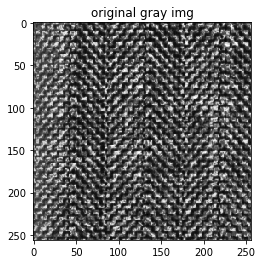

In [145]:
# now start to create a glcm feature image by sliding over the gray image

image_file = './output/subimg-mosaic2-1.png'
gray_img = cv2.imread(image_file,cv2.IMREAD_GRAYSCALE)  # read image by opencv as grayscale 
req_img = requantize(gray_img, level_num = 10)

M, N = req_img.shape
feature_img = np.zeros([M, N])
win_order = 7
feature = 'correlation'

start_time = time.time()

for i in range(M):
    for j in range(N):
        win_img = glcm_window_img(req_img, neighbor= win_order, current_row = i, current_col=j, fill='mirror')
        glcm_istr = isotropic_glcm(win_img)
        feature_img[i,j] = glcm_measures(glcm_istr,name = feature, normed=True, symmetric=True)
        
end_time = time.time()
print('Running time: ', end_time - start_time)

# scale imge (0-255)
im_max = np.nanmax(feature_img) # if using np.max, sometimes will return Nan values
im_min = np.nanmin(feature_img)

feature_img = (1 - (im_max - feature_img)/(im_max - im_min))*255

plt.imshow(gray_img,'gray')
plt.title('original gray img')
plt.show()


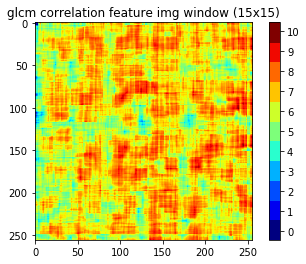

[[  16.19332791   19.73169013    4.54993646   69.04363925  149.52661826]
 [  14.13456251   17.51776166    5.82272675   61.07144311  126.1449951 ]
 [   3.24776389    6.82812737    0.           43.51825732  100.22241053]
 [  27.08644895   15.93830678   20.22856407   62.23254732  101.48844333]
 [  89.85040623   71.54473511   60.27395166   94.35240521  114.05588896]]


In [154]:
# Make plot with vertical (default) colorbar
from matplotlib import cm
import matplotlib.colors as mcolors

# these two functions copied 
# from https://stackoverflow.com/questions/18704353/correcting-matplotlib-colorbar-ticks

def colorbar_index(ncolors, cmap):
    cmap = cmap_discretize(cmap, ncolors)
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(range(ncolors))

def cmap_discretize(cmap, N):
    """Return a discrete colormap from the continuous colormap cmap.

        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.

    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)
    """

    if type(cmap) == str:
        cmap = plt.get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0.,0.,0.,0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N+1)
    cdict = {}
    for ki,key in enumerate(('red','green','blue')):
        cdict[key] = [ (indices[i], colors_rgba[i-1,ki], colors_rgba[i,ki])
                       for i in range(N+1) ]
    # Return colormap object.
    return mcolors.LinearSegmentedColormap(cmap.name + "_%d"%N, cdict, 1024)

fig, ax = plt.subplots()

cmap = plt.get_cmap('jet')

cax = ax.imshow(feature_img, interpolation='nearest', cmap=cmap)
ax.set_title('glcm correlation feature img window (15x15)')
colorbar_index(ncolors=11, cmap=cmap) 

plt.show()


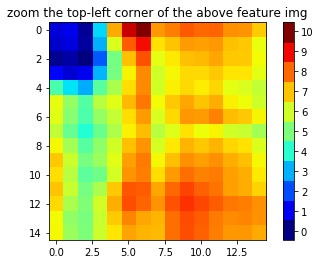

In [160]:
#print(feature_img[0:10,0:10])
crop_img = feature_img[0:15,0:15]
fig, ax = plt.subplots()

cax = ax.imshow(crop_img, interpolation='nearest', cmap=cmap)
ax.set_title('zoom the top-left corner of the above feature img')
colorbar_index(ncolors=11, cmap=cmap) 

plt.show()